In [56]:
from riversim import *

outer_boundary = Boundary()
outer_boundary.vertices.extend([Point(0.13, 0.011), Point(0.31, 0), 
    Point(0.74, 0.15), Point(0.95, 0.35), Point(0.8, 0.75), 
    Point(0.47, 0.85), Point(0.152, 0.76), Point(0, 0.5), Point(0.025, 0.3)])
outer_boundary.lines.extend([Line(0, 1, 1), Line(1, 2, 1), 
    Line(2, 3, 1), Line(3, 4, 1), Line(4, 5, 2), Line(5, 6, 2), 
    Line(6, 7, 1), Line(7, 8, 1), Line(8, 0, 1)])

inner_boundary = Boundary()
inner_boundary.vertices.extend([Point(0.3, 0.7), Point(0.5, 0.76), Point(0.65, 0.7), Point(0.66, 0.59)])
inner_boundary.lines.extend([Line(0, 1, 1), Line(1, 2, 3), 
    Line(2, 3, 3), Line(3, 0, 1)])

region = Region()
region[1] = outer_boundary; region[2] = inner_boundary
region.holes.append(Point(0.4, 0.7))

sources = Sources()
sources[1] = t_source_coord(1, 1) 
sources[2] = t_source_coord(1, 8) 
sources[3] = t_source_coord(2, 3)

In [48]:
import matplotlib.pyplot as plt

x = []
y = []
for boundary_pr in region:
    x = x + [v.x for v in boundary_pr.data().vertices]
    y = y + [v.y for v in boundary_pr.data().vertices]
    x.append(boundary_pr.data().vertices[0].x)
    #y.append(boundary_pr.data().vertices[0].y)

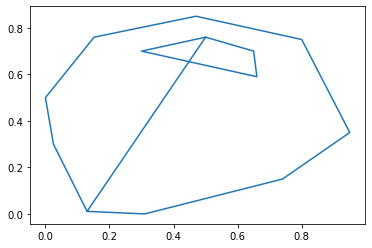

In [49]:
plt.plot(x, y)

In [41]:
rivers = Rivers()
rivers.initialize(region.getSourcesIdsPointsAndAngles(sources))

In [42]:
rivers_ids = t_sources_ids(); rivers_ids.extend([1, 2, 3])
ds = 0.01
tip_points = t_PolarList(); tip_points.extend([Polar(ds, 0), Polar(ds, 0), Polar(ds, 0)])
boundaries_ids = t_boundaries_ids(); boundaries_ids.extend([1, 2, 1])
rivers.addPolars(rivers_ids, tip_points, boundaries_ids)
rivers.addPolars(rivers_ids, tip_points, boundaries_ids)

sub_branch_ids = rivers.createSubBranches(1, -3.1415/5, 3.1415/5)


In [6]:
RegionParams()

{
    "ignored_smoothness_length": 0.01,
    "river_boundary_id": 100,
    "river_width": 1e-07,
    "smoothness_degree": 0.2
}

In [50]:
region_params = RegionParams()
region_params.smoothness_degree = 0.2
region_params.river_width = 1e-8
boundary = BoundaryGenerator(sources, region, rivers, region_params)

In [51]:
import matplotlib.pyplot as plt

x = []
y = []
x = x + [v.x for v in boundary.vertices]
y = y + [v.y for v in boundary.vertices]
x.append(boundary.vertices[0].x)
y.append(boundary.vertices[0].y)

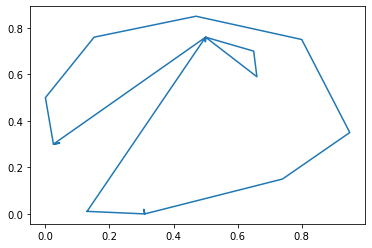

In [52]:
plt.plot(x, y)

In [20]:
mesh_params = MeshParams()
mesh_params.max_area = 1e6
mesh_params.min_area = 6e-7
mesh_params.max_edge = 1
mesh_params.min_edge = 8e-12
mesh_params.ratio = 2.3
mesh_params.refinment_radius = 5e-3
mesh_params.exponant = 1
mesh_params.sigma = 1.9

In [21]:
triangle = Triangle(mesh_params)

In [22]:
mesh = triangle.generate(boundary, region.holes)

In [23]:
mesh.write("lala.msh")

In [66]:
solver_params = SolverParams()
solver_params.field_value = 1
solver_params.quadrature_degree = 3
solver_params.renumbering_type = 0
solver_params.tollerance = 1e-12
solver_params.num_of_iterrations =  6000
solver_params.refinment_fraction = 0.1

solver = Solver(solver_params)

solver.openMesh(mesh)

In [62]:
solver_params

{
    "adaptive_refinment_steps": 0,
    "field_value": 1.0,
    "num_of_iterrations": 6000,
    "quadrature_degree": 3,
    "refinment_fraction": 0.1,
    "renumbering_type": 0,
    "static_refinment_steps": 0,
    "tollerance": 1e-12
}

In [ ]:
integration_params = IntegrationParams()
integration_params.eps = 1e-10
integration_params.integration_radius = 3e-2
integration_params.exponant = 2.0
integration_params.weigth_func_radius = 1e-2


tip_point = rivers[1].tipPoint()
tip_angle = rivers[1].tipAngle()

ids_series_params = t_ids_series_params()
ids_series_params[1] = solver.integrate_new(integration_params, tip_point, tip_angle)

: 

: 

In [144]:
np.logspace(-1, -9, 10)

array([1.00000000e-01, 1.29154967e-02, 1.66810054e-03, 2.15443469e-04,
       2.78255940e-05, 3.59381366e-06, 4.64158883e-07, 5.99484250e-08,
       7.74263683e-09, 1.00000000e-09])

In [11]:
import riversim
import numpy as np


par = np.logspace(0, -2, 10)
a1_ev = []
a1_a = []
dev_in_per = []
mesh_size = []

for p in par:

    model = riversim.Model()
    model.height = 50; model.width = 2; model.dx = 1;
    model.initializeLaplace()

    H = 1
    model.solver_params.adaptive_refinment_steps = 1
    model.rivers[1].addPoint(riversim.Polar(H, 0), 0)
    
    boundary = riversim.BoundaryGenerator(model.sources, model.region, model.rivers, model.region_params)
    triangle = riversim.Triangle(model.mesh_params)
    triangle.mesh_params.refinment_radius = 0.002
    triangle.mesh_params.exponant = 2
    triangle.mesh_params.min_area = 1e-9
    triangle.mesh_params.tip_points = model.rivers.tipPoints()
    mesh = triangle.generate(boundary, model.region.holes)
    mesh.write("test" + str(p) + ".msh")
    model.solver_params.quadrature_degree = 4
    solver = riversim.Solver(model.solver_params)
    solver.openMesh(mesh)
    for i in range(1 + model.solver_params.adaptive_refinment_steps):
        if i > 0:
            solver.refineGrid()
        solver.setupSystem()
        solver.assembleSystem(model.boundary_conditions)
        solver.solve()

    tip_angle = model.rivers[1].tipAngle()
    tip_coord = model.rivers[1].tipPoint()

    #series_params_old = solver.integrate(model.integr_params, tip_coord, tip_angle)
    #series_params_new = solver.integrate_new(model.integr_params, tip_coord, tip_angle)
    model.integr_params.eps = p
    model.integr_params.integration_radius = 0.0001
    model.integr_params.weigth_func_radius = 0.003
    series_params_trap = solver.integrate_trap(model.integr_params, tip_coord, tip_angle)
    a_analitic = np.sqrt(4/np.pi*np.tanh(np.pi/2 * H))
    #print(series_params_old[0])
    #print(series_params_new[0])
    print(series_params_trap[0])
    print(a_analitic)
    a1_ev += [series_params_trap[0]]
    a1_a += [a_analitic]
    mesh_size += [mesh.getNQuadrangles()]
    dev_in_per += [100 * abs((1 - series_params_trap[0] / a_analitic))]
    print(100*(1 - series_params_trap[0] / a_analitic))

1.087557516654412
1.0806269579821668
-0.6413460834982843
1.0809547373030373
1.0806269579821668
-0.030332328695781285
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432


In [141]:
dev_in_per

[60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863]

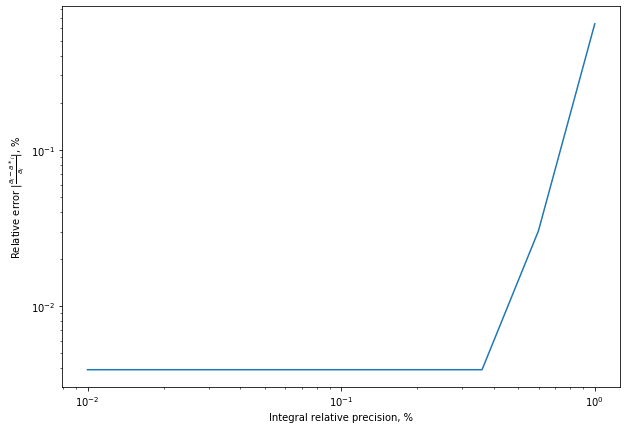

In [12]:
import matplotlib.pyplot as plt
plt.loglog(par, dev_in_per)
plt.ylabel(r'Relative error $|\frac{a_i - a*_i}{a_i}|$, %')
plt.xlabel("Integral relative precision, %")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig("convergence_by_integral_precision.png")

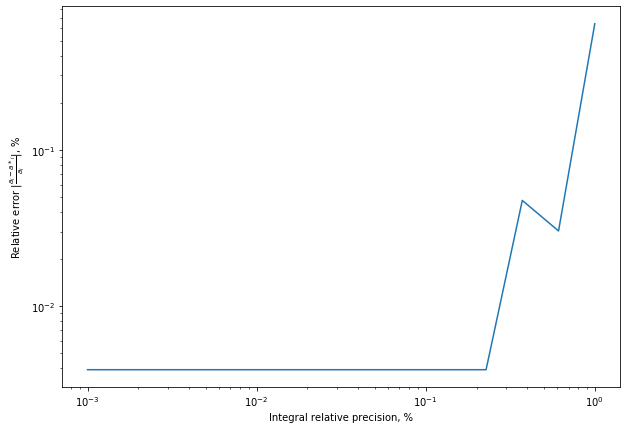

In [10]:
import matplotlib.pyplot as plt
plt.loglog(par, dev_in_per)
plt.ylabel(r'Relative error $|\frac{a_i - a*_i}{a_i}|$, %')
plt.xlabel("Integral relative precision, %")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig("convergence_by_integral_precision.png")

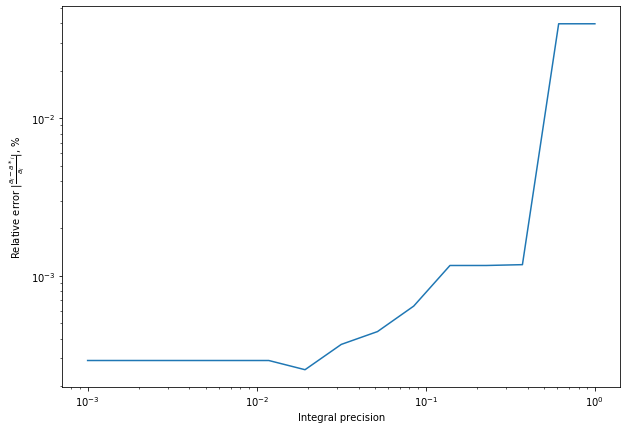

In [5]:
import matplotlib.pyplot as plt
plt.loglog(par, dev_in_per)
plt.ylabel(r'Relative error $|\frac{a_i - a*_i}{a_i}|$, %')
plt.xlabel("Integral precision")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig("convergence_by_integral_precision.png")

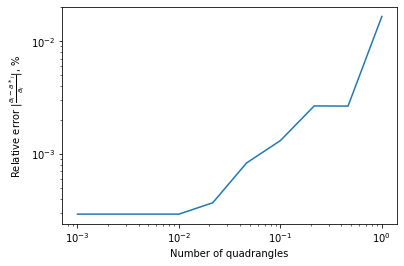

In [2]:
import matplotlib.pyplot as plt
plt.loglog(par, dev_in_per)
plt.ylabel(r'Relative error $|\frac{a_i - a*_i}{a_i}|$, %')
plt.xlabel("Integral precision")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig("convergence_by_integral_precision.png")

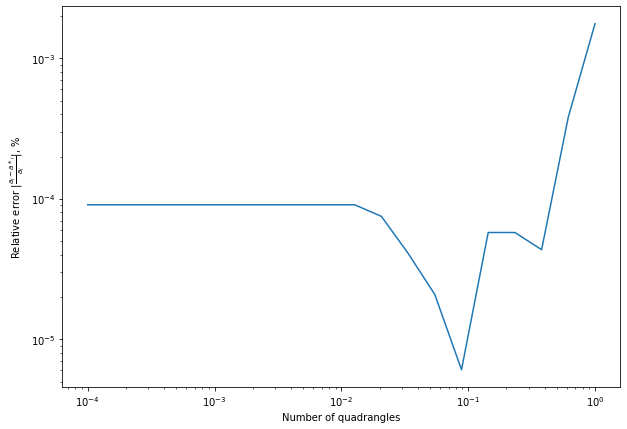

In [171]:
import matplotlib.pyplot as plt
plt.loglog(par, dev_in_per)
plt.ylabel(r'Relative error $|\frac{a_i - a*_i}{a_i}|$, %')
plt.xlabel("Number of quadrangles")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig("convergence_by_integral_precision.png")

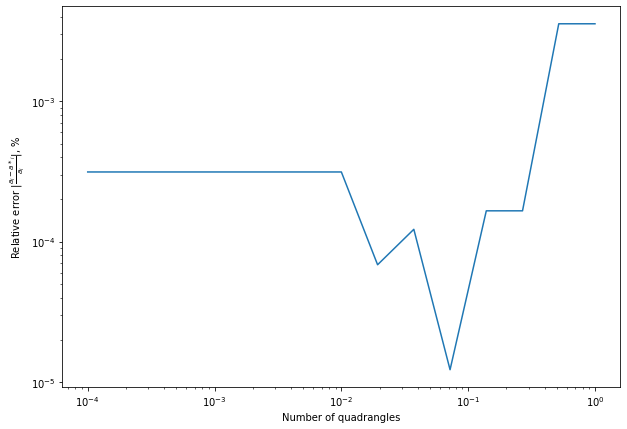

In [169]:
import matplotlib.pyplot as plt
plt.loglog(par, dev_in_per)
plt.ylabel(r'Relative error $|\frac{a_i - a*_i}{a_i}|$, %')
plt.xlabel("Number of quadrangles")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig("convergence_by_integral_precision.png")